In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pygal
from IPython.display import display, HTML
from pygal.style import Style

# for modelling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [ ]:
train = pd.read_csv('train.csv')
target = pd.read_csv('target.csv')
test = pd.read_csv('test.csv')

train[['amount_tsh', 'num_private', 'population' ,'construction_year']] = \
    train[['amount_tsh', 'num_private', 'population' ,'construction_year']].replace(0, np.NaN)

train.drop(['wpt_name', 'recorded_by', 'longitude', 'latitude','scheme_name', 'num_private'], 1, inplace=True)

train[['region_code', 'district_code']]= train[['region_code', 'district_code']].astype('object')
train[['date_recorded', 'construction_year']]= train[['date_recorded', 'construction_year']].apply((pd.to_datetime))

categoricals = train.select_dtypes(include = ['object']).columns.tolist()
numerical = train.select_dtypes(include = ['int', 'float']).columns.tolist()
date_cols = train.select_dtypes(include = ['datetime64']).columns.tolist()

df = pd.merge(train, target, how = 'inner', on = 'id')

df.drop('id', 1, inplace=True)

df['missed_population'] = np.where(np.isnan(df['population']), 1, 0)
df['population'].fillna(0, inplace = True)

df.isnull().amount_tsh.sum()

df['approximated_amount_tsh'] = np.where(np.isnan(df['amount_tsh']), 1, 0) 
replacements = df.groupby('water_quality').amount_tsh.agg(pd.Series.mode).to_dict()

# all vlaues amount_tsh in this category is Nan
replacements.pop('fluoride abandoned')

df.loc[df['water_quality'] != 'soft', 'amount_tsh'] = \
    df.loc[df['water_quality'] != 'soft', 'amount_tsh'].fillna(replacements)

df['amount_tsh'].fillna(0, inplace=True)

In [ ]:
df['wrong_gps_height'] = np.where(df['gps_height'] < 0, 1, 0) 
df['gps_height'] = abs(df['gps_height'])

In [ ]:
df[categoricals] = df[categoricals].astype('str')
df[categoricals] = df[categoricals].applymap(lambda x: x.lower())
nan_list = ['not known','unknown','none','-','##','not kno','unknown installer', '0', 'dwe']
df = df.replace(nan_list, np.nan)

In [ ]:
wp_in_subvillages = df['subvillage'].value_counts().to_dict()
df['wp_in_subvillage'] = df['subvillage'].replace(wp_in_subvillages)
df['wp_in_subvillage'].fillna(1, inplace=True)

wp_in_lga = df['lga'].value_counts().to_dict()
df['wp_in_lga'] = df['lga'].replace(wp_in_lga)

wp_in_ward = df['ward'].value_counts().to_dict()
df['wp_in_ward'] = df['ward'].replace(wp_in_ward)

df.drop(['subvillage', 'lga', 'ward'],1, inplace=True)

In [ ]:
categoricals = df.select_dtypes(include = ['object']).columns.tolist()
# Any feature values with fewer than 50 rows would be turned into a 'other'
for feature in df[categoricals]:
    # Determine which feature values to keep
    remove = df[feature].value_counts()[df[feature].value_counts() < 50].index.tolist()
    #print(remove)
    #to_keep = train[feature].value_counts()[train[feature].value_counts() > 50].index.tolist()
    
    # Turn those into NANs (using a copy, to prevent warnings)
    feature_copy = df[feature].copy()
    #feature_copy[~feature_copy.isin(to_keep)] = np.nan
    feature_copy[feature_copy.isin(remove)] = np.nan
    #print(feature_copy.isnull().sum())
    df[feature] = feature_copy
# Fix all NANs
df[categoricals] = df[categoricals].fillna('other')

In [ ]:
# I checked that Tanzania has 31 region, so I will drop column 'region', beckause there is less values
df.drop(['region', 'district_code'], 1, inplace=True)

# extraction_type has very close values with extraction_type_group and extraction_type_class but extraction_type
# has more values so I will 
# remove extraction_type_group, extraction_type_class

df.drop('extraction_type_group', 1, inplace=True)
df.drop('extraction_type_class', 1, inplace=True)

# majority of 'management' looks the same so I will remove this columns and leave 'management_group' 
# and join small columns to 'other' 
df.management_group = df.management_group.apply(lambda x: 'other' if x != 'user-group' else x)

# need to check shares in groups but nice and remove it
# distribution in classes looks the same and this is not informative, will remove it
df.drop(['management', 'management_group'], 1, inplace=True)

# join pay to 1 group and others to another
unpayable_types = ['never pay', 'other']
df.payment = df.payment.apply(lambda x: 0 if x in unpayable_types else 1)
df['payment']= df['payment'].astype('object')

df.drop('payment_type', 1, inplace=True)
# beckause payment shows the same info

# quality_group looks very close to water_quality, so I will remove one
df.drop(['water_quality'], 1, inplace=True)

# quantity_group and quantity have the same info, so I will remove second one and join 'other' with 'dry' 
# beckause it small group
df.drop(['quantity_group'], 1, inplace=True)

#df.quantity = 
df.quantity.replace({'dry': 'other'}, inplace=True)

# I will drop source_class and source_type becuase source is more detailed
df.drop(['source_class', 'source_type'], 1, inplace=True)

# waterpoint_type_group and waterpoint_type looks the same but  waterpoint_type more detailed
df.drop('waterpoint_type_group', 1, inplace=True)

# I will join 2 small classes with close distribution
df.waterpoint_type.replace({'cattle trough':'improved spring'}, inplace=True)

In [ ]:
df.construction_year.fillna(0, inplace=True)
df.construction_year = df.construction_year.astype(int)


In [ ]:
df.construction_year = df.construction_year.replace(0, np.NaN)
# add column that means that construction_year was filled with approximation
df['approximated_construction_year'] = df['construction_year'].apply(lambda x: 1 if np.isnan(x) else 0)

replacements = df.groupby(['funder', 'installer'])['construction_year'].transform('mean').round(0)
df['construction_year'] = df['construction_year'].fillna(replacements)

replacements = df.groupby('installer')['construction_year'].transform('mean').round(0)
df['construction_year'] = df['construction_year'].fillna(replacements)

replacements = df.groupby('funder')['construction_year'].transform('mean').round(0)
df['construction_year'] = df['construction_year'].fillna(replacements)

df.construction_year.fillna(df.construction_year.mode()[0], inplace=True)

In [ ]:
df['lifetimes'] = df['date_recorded'].dt.year - df['construction_year']
df['lifetimes'] = np.where(df['lifetimes'] < 0, 0, df['lifetimes'] )

In [ ]:
df.drop(['date_recorded', 'construction_year'], 1, inplace=True)

In [13]:
df.to_csv('prepeared_features.csv', index=False)

In [9]:
df['wp_in_subvillage'] = df['wp_in_subvillage'].astype(int)
df['payment']= df['payment'].astype('object')

# modelling

In [2]:
df = pd.read_csv('prepeared_features.csv')

/Users/danil/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.dtypes

amount_tsh                        float64
funder                             object
gps_height                          int64
installer                          object
basin                              object
region_code                        object
population                        float64
public_meeting                     object
scheme_management                  object
permit                             object
extraction_type                    object
payment                             int64
quality_group                      object
quantity                           object
source                             object
waterpoint_type                    object
status_group                       object
missed_population                   int64
approximated_amount_tsh             int64
wrong_gps_height                    int64
wp_in_subvillage                  float64
wp_in_lga                           int64
wp_in_ward                          int64
approximated_construction_year    

ww cat features
1. onehotencod
give the same num of columns as dummy
2. target_encoding
LR: 0.669481 (0.006335)
RF: 0.776119 (0.007765)
3. dummy_encode
LR: 0.746746 (0.006960)
RF: 0.780567 (0.007248)
4. drop unnecessury features
selected -3
LR: 0.730112 (0.007359)
RF: 0.779788 (0.003643)
ww numeric features
1. normalize
LR: 0.717146 (0.007618)
RF: 0.781848 (0.005260)
2. log
LR: 0.719659 (0.006688)
RF: 0.783557 (0.006206)
3. minMax
LR: 0.730891 (0.007700)
RF: 0.784662 (0.005118)
4. robust
LR: 0.727825 (0.007459)
RF: 0.773531 (0.004417)
5. drop unnecessury
ww models
1. install xgboost or lightgbm
2. install cat boost
3. NN
4. randomGridSearch for best model
predict on test data and validate results

In [140]:
df['payment']= df['payment'].astype('int')

In [150]:
numerical = df.select_dtypes(include = ['float64', 'int64']).columns.tolist()

In [186]:
numerical = ['amount_tsh', 'gps_height', 'population', 'wp_in_subvillage', 'wp_in_lga', 'wp_in_ward', 'lifetimes']

In [172]:
df.dtypes

amount_tsh                        float64
funder                             object
gps_height                          int64
installer                          object
basin                              object
region_code                        object
population                        float64
public_meeting                     object
scheme_management                  object
permit                             object
extraction_type                    object
payment                             int64
quality_group                      object
quantity                           object
source                             object
waterpoint_type                    object
status_group                        int64
missed_population                   int64
approximated_amount_tsh             int64
wrong_gps_height                    int64
wp_in_subvillage                  float64
wp_in_lga                           int64
wp_in_ward                          int64
approximated_construction_year    

In [173]:
numerical

['amount_tsh',
 'gps_height',
 'population',
 'wp_in_subvillage',
 'wp_in_lga',
 'wp_in_ward',
 'lifetimes']

In [182]:
from sklearn import preprocessing

df[numerical] = preprocessing.normalize(df[numerical].values)

In [20]:
df.status_group = df.status_group.replace(['functional', 'non functional', 'functional needs repair'], [2, 0, 1])

In [21]:
target = df.status_group
train = df.drop('status_group', 1)
numerical = train.select_dtypes(include = ['float64', 'int64']).columns.tolist()

In [196]:
# normalization
train[numerical] = preprocessing.normalize(train[numerical].values)

In [174]:
# robost
scaler = RobustScaler()
nums_scaled = scaler.fit_transform(df[numerical])
nums_scaled = pd.DataFrame(nums_scaled, columns=numerical)
df[numerical] = nums_scaled

In [268]:
# minMax
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train[numerical].values)
train[numerical] = scaler.transform(train[numerical].values)

In [226]:
# log
train[numerical] = np.log(train[numerical].values)

train[numerical] = train[numerical].replace([np.inf, -np.inf], 0)

/Users/danil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [245]:
cols_to_keep = train.select_dtypes(exclude=['number']).nunique().sort_values().index.tolist()[:-3]

In [246]:
cols_to_keep

['public_meeting',
 'permit',
 'quantity',
 'waterpoint_type',
 'quality_group',
 'basin',
 'source',
 'scheme_management',
 'extraction_type']

In [7]:
non_categorial = train.select_dtypes(exclude = ['object']).columns.tolist()
categorial = train.select_dtypes(include = ['object']).columns.tolist()

In [269]:
train_dum = pd.get_dummies(train[cols_to_keep], dummy_na=False, prefix = cols_to_keep)
train_dum.shape

(59400, 63)

In [270]:
df_preproc = pd.concat([train_dum, train[non_categorial]], 1)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.33, random_state=42)

In [256]:
import lightgbm as lgb

In [308]:
lg = lgb.LGBMClassifier(objective = 'multiclass' , silent=False,
                       num_leaves=90, n_estimators=20, max_depth=50, learning_rate=0.1)

In [309]:
lg.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=50,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=20, n_jobs=-1, num_leaves=90, objective='multiclass',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
param_dist = {"max_depth": [25,50, 75],
              "learning_rate" : [0.01,0.05,0.1],
              "num_leaves": [10, 30,90,120],
              "n_estimators": [5, 10, 20]
             }
grid_search = RandomizedSearchCV(lg, n_jobs=4, n_iter = 2, param_distributions=param_dist, cv = 3, 
                                 scoring="roc_auc", verbose=3, )
grid_search.fit(X_train,y_train)
grid_search.best_estimator_

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] num_leaves=120, n_estimators=10, max_depth=50, learning_rate=0.1 
[CV] num_leaves=120, n_estimators=10, max_depth=50, learning_rate=0.1 
[CV] num_leaves=120, n_estimators=10, max_depth=50, learning_rate=0.1 
[CV] num_leaves=120, n_estimators=20, max_depth=25, learning_rate=0.01 


In [310]:
y_pred=lg.predict(X_test)

In [33]:
accuracy_score(y_test, y_pred, normalize=True)

0.3305785123966942

In [312]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.85      0.65      0.74      7458
          1       0.73      0.18      0.28      1425
          2       0.74      0.93      0.82     10719

avg / total       0.78      0.77      0.75     19602



In [23]:
X_train.fillna(0, inplace=True)

/Users/danil/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


In [35]:
import catboost as cb

params = {'depth': [4, 7, 10],
          'learning_rate' : [0.03, 0.1, 0.15],
         'l2_leaf_reg': [1,4,9],
         'iterations': [300]}
cb = cb.CatBoostClassifier(loss_function='MultiClass', cat_features=categorial)
cb.fit(X_train, y_train)
#cb_model = RandomizedSearchCV(cb, params, scoring="roc_auc", cv = 3, n_jobs=4)
#cb_model.fit(X_train, y_train)

0:	learn: -1.0762851	total: 462ms	remaining: 7m 41s
1:	learn: -1.0555408	total: 958ms	remaining: 7m 57s
2:	learn: -1.0360800	total: 1.4s	remaining: 7m 44s
3:	learn: -1.0183194	total: 1.82s	remaining: 7m 33s
4:	learn: -1.0012297	total: 2.28s	remaining: 7m 32s
5:	learn: -0.9851964	total: 2.69s	remaining: 7m 25s
6:	learn: -0.9701619	total: 3.12s	remaining: 7m 21s
7:	learn: -0.9572234	total: 3.38s	remaining: 6m 59s
8:	learn: -0.9437762	total: 3.82s	remaining: 7m
9:	learn: -0.9308641	total: 4.35s	remaining: 7m 10s
10:	learn: -0.9189119	total: 4.77s	remaining: 7m 9s
11:	learn: -0.9080130	total: 5.2s	remaining: 7m 7s
12:	learn: -0.8968834	total: 5.66s	remaining: 7m 9s
13:	learn: -0.8864320	total: 6.09s	remaining: 7m 9s
14:	learn: -0.8771565	total: 6.52s	remaining: 7m 8s
15:	learn: -0.8681724	total: 6.97s	remaining: 7m 8s
16:	learn: -0.8592890	total: 7.42s	remaining: 7m 8s
17:	learn: -0.8511714	total: 7.84s	remaining: 7m 7s
18:	learn: -0.8430494	total: 8.28s	remaining: 7m 7s
19:	learn: -0.8357

152:	learn: -0.6158887	total: 1m 53s	remaining: 10m 26s
153:	learn: -0.6156517	total: 1m 53s	remaining: 10m 24s
154:	learn: -0.6152305	total: 1m 54s	remaining: 10m 21s
155:	learn: -0.6147315	total: 1m 54s	remaining: 10m 19s
156:	learn: -0.6144987	total: 1m 54s	remaining: 10m 16s
157:	learn: -0.6141228	total: 1m 55s	remaining: 10m 14s
158:	learn: -0.6136611	total: 1m 55s	remaining: 10m 12s
159:	learn: -0.6133125	total: 1m 56s	remaining: 10m 11s
160:	learn: -0.6130662	total: 1m 57s	remaining: 10m 10s
161:	learn: -0.6127852	total: 1m 57s	remaining: 10m 8s
162:	learn: -0.6124820	total: 1m 58s	remaining: 10m 6s
163:	learn: -0.6120611	total: 1m 58s	remaining: 10m 4s
164:	learn: -0.6120209	total: 1m 58s	remaining: 10m
165:	learn: -0.6115677	total: 1m 59s	remaining: 9m 58s
166:	learn: -0.6110743	total: 1m 59s	remaining: 9m 56s
167:	learn: -0.6108359	total: 2m	remaining: 9m 54s
168:	learn: -0.6104463	total: 2m	remaining: 9m 52s
169:	learn: -0.6101532	total: 2m	remaining: 9m 50s
170:	learn: -0.6

303:	learn: -0.5801265	total: 3m 31s	remaining: 8m 4s
304:	learn: -0.5799652	total: 3m 32s	remaining: 8m 3s
305:	learn: -0.5798710	total: 3m 32s	remaining: 8m 2s
306:	learn: -0.5797888	total: 3m 33s	remaining: 8m 1s
307:	learn: -0.5796259	total: 3m 33s	remaining: 8m
308:	learn: -0.5793315	total: 3m 34s	remaining: 7m 59s
309:	learn: -0.5792005	total: 3m 35s	remaining: 7m 59s
310:	learn: -0.5790342	total: 3m 35s	remaining: 7m 58s
311:	learn: -0.5788561	total: 3m 36s	remaining: 7m 57s
312:	learn: -0.5785317	total: 3m 36s	remaining: 7m 56s
313:	learn: -0.5783900	total: 3m 37s	remaining: 7m 55s
314:	learn: -0.5782781	total: 3m 37s	remaining: 7m 53s
315:	learn: -0.5781829	total: 3m 38s	remaining: 7m 52s
316:	learn: -0.5781280	total: 3m 39s	remaining: 7m 51s
317:	learn: -0.5778467	total: 3m 39s	remaining: 7m 50s
318:	learn: -0.5776362	total: 3m 40s	remaining: 7m 49s
319:	learn: -0.5773084	total: 3m 40s	remaining: 7m 48s
320:	learn: -0.5770941	total: 3m 41s	remaining: 7m 47s
321:	learn: -0.576

454:	learn: -0.5570198	total: 5m	remaining: 5m 59s
455:	learn: -0.5569318	total: 5m	remaining: 5m 58s
456:	learn: -0.5568340	total: 5m	remaining: 5m 57s
457:	learn: -0.5567423	total: 5m 1s	remaining: 5m 56s
458:	learn: -0.5566224	total: 5m 1s	remaining: 5m 55s
459:	learn: -0.5564033	total: 5m 2s	remaining: 5m 54s
460:	learn: -0.5562621	total: 5m 2s	remaining: 5m 53s
461:	learn: -0.5561221	total: 5m 3s	remaining: 5m 53s
462:	learn: -0.5560441	total: 5m 3s	remaining: 5m 52s
463:	learn: -0.5559309	total: 5m 4s	remaining: 5m 51s
464:	learn: -0.5558469	total: 5m 6s	remaining: 5m 52s
465:	learn: -0.5557930	total: 5m 8s	remaining: 5m 53s
466:	learn: -0.5556859	total: 5m 9s	remaining: 5m 52s
467:	learn: -0.5555647	total: 5m 9s	remaining: 5m 52s
468:	learn: -0.5554751	total: 5m 10s	remaining: 5m 51s
469:	learn: -0.5553975	total: 5m 11s	remaining: 5m 51s
470:	learn: -0.5552433	total: 5m 12s	remaining: 5m 50s
471:	learn: -0.5551408	total: 5m 12s	remaining: 5m 49s
472:	learn: -0.5549878	total: 5m 

605:	learn: -0.5429003	total: 6m 29s	remaining: 4m 13s
606:	learn: -0.5428313	total: 6m 29s	remaining: 4m 12s
607:	learn: -0.5427850	total: 6m 30s	remaining: 4m 11s
608:	learn: -0.5426526	total: 6m 30s	remaining: 4m 10s
609:	learn: -0.5425164	total: 6m 31s	remaining: 4m 10s
610:	learn: -0.5424560	total: 6m 33s	remaining: 4m 10s
611:	learn: -0.5424196	total: 6m 33s	remaining: 4m 9s
612:	learn: -0.5423871	total: 6m 34s	remaining: 4m 9s
613:	learn: -0.5422856	total: 6m 35s	remaining: 4m 8s
614:	learn: -0.5421334	total: 6m 36s	remaining: 4m 7s
615:	learn: -0.5420669	total: 6m 36s	remaining: 4m 7s
616:	learn: -0.5419957	total: 6m 37s	remaining: 4m 6s
617:	learn: -0.5419309	total: 6m 37s	remaining: 4m 5s
618:	learn: -0.5418132	total: 6m 38s	remaining: 4m 4s
619:	learn: -0.5417777	total: 6m 38s	remaining: 4m 4s
620:	learn: -0.5416797	total: 6m 39s	remaining: 4m 3s
621:	learn: -0.5416172	total: 6m 39s	remaining: 4m 2s
622:	learn: -0.5415686	total: 6m 40s	remaining: 4m 2s
623:	learn: -0.5414844

756:	learn: -0.5318487	total: 7m 50s	remaining: 2m 31s
757:	learn: -0.5317623	total: 7m 51s	remaining: 2m 30s
758:	learn: -0.5317090	total: 7m 51s	remaining: 2m 29s
759:	learn: -0.5316335	total: 7m 52s	remaining: 2m 29s
760:	learn: -0.5315586	total: 7m 52s	remaining: 2m 28s
761:	learn: -0.5314944	total: 7m 53s	remaining: 2m 27s
762:	learn: -0.5313798	total: 7m 53s	remaining: 2m 27s
763:	learn: -0.5313101	total: 7m 54s	remaining: 2m 26s
764:	learn: -0.5312599	total: 7m 54s	remaining: 2m 25s
765:	learn: -0.5311898	total: 7m 55s	remaining: 2m 25s
766:	learn: -0.5311704	total: 7m 55s	remaining: 2m 24s
767:	learn: -0.5310780	total: 7m 55s	remaining: 2m 23s
768:	learn: -0.5309683	total: 7m 56s	remaining: 2m 23s
769:	learn: -0.5308551	total: 7m 56s	remaining: 2m 22s
770:	learn: -0.5307685	total: 7m 57s	remaining: 2m 21s
771:	learn: -0.5307227	total: 7m 57s	remaining: 2m 21s
772:	learn: -0.5306401	total: 7m 58s	remaining: 2m 20s
773:	learn: -0.5305532	total: 7m 58s	remaining: 2m 19s
774:	learn

907:	learn: -0.5228964	total: 9m 4s	remaining: 55.1s
908:	learn: -0.5228134	total: 9m 4s	remaining: 54.5s
909:	learn: -0.5227624	total: 9m 5s	remaining: 53.9s
910:	learn: -0.5227168	total: 9m 5s	remaining: 53.3s
911:	learn: -0.5226322	total: 9m 6s	remaining: 52.7s
912:	learn: -0.5225485	total: 9m 6s	remaining: 52.1s
913:	learn: -0.5225034	total: 9m 7s	remaining: 51.5s
914:	learn: -0.5223772	total: 9m 7s	remaining: 50.9s
915:	learn: -0.5223262	total: 9m 8s	remaining: 50.3s
916:	learn: -0.5222923	total: 9m 8s	remaining: 49.6s
917:	learn: -0.5222108	total: 9m 9s	remaining: 49s
918:	learn: -0.5221443	total: 9m 9s	remaining: 48.4s
919:	learn: -0.5221035	total: 9m 10s	remaining: 47.8s
920:	learn: -0.5220710	total: 9m 10s	remaining: 47.2s
921:	learn: -0.5220486	total: 9m 11s	remaining: 46.6s
922:	learn: -0.5219125	total: 9m 11s	remaining: 46s
923:	learn: -0.5218877	total: 9m 12s	remaining: 45.4s
924:	learn: -0.5218328	total: 9m 12s	remaining: 44.8s
925:	learn: -0.5217929	total: 9m 13s	remaini

In [27]:
X_test.fillna(0, inplace=True)

/Users/danil/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


In [36]:
y_pred=cb.predict(X_test)

In [37]:
accuracy_score(y_test, y_pred, normalize=True)

0.7842567084991328

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.72      0.77      7458
           1       0.64      0.19      0.29      1425
           2       0.77      0.91      0.83     10719

    accuracy                           0.78     19602
   macro avg       0.74      0.61      0.63     19602
weighted avg       0.78      0.78      0.77     19602



In [ ]:
With Categorical features
clf = cb.CatBoostClassifier(eval_metric="AUC", depth=10, iterations= 500, l2_leaf_reg= 9, learning_rate= 0.15)
clf.fit(train,y_train)
auc(clf, train, test)

With Categorical features
clf = cb.CatBoostClassifier(eval_metric="AUC",one_hot_max_size=31, \
                            depth=10, iterations= 500, l2_leaf_reg= 9, learning_rate= 0.15)
clf.fit(train,y_train, cat_features= cat_features_index)
auc(clf, train, test)

In [260]:
models = []

models.append(('LR', LogisticRegression()))
models.append(('RF', RandomForestClassifier(n_jobs=-1)))


#testing models

results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

KeyboardInterrupt: 

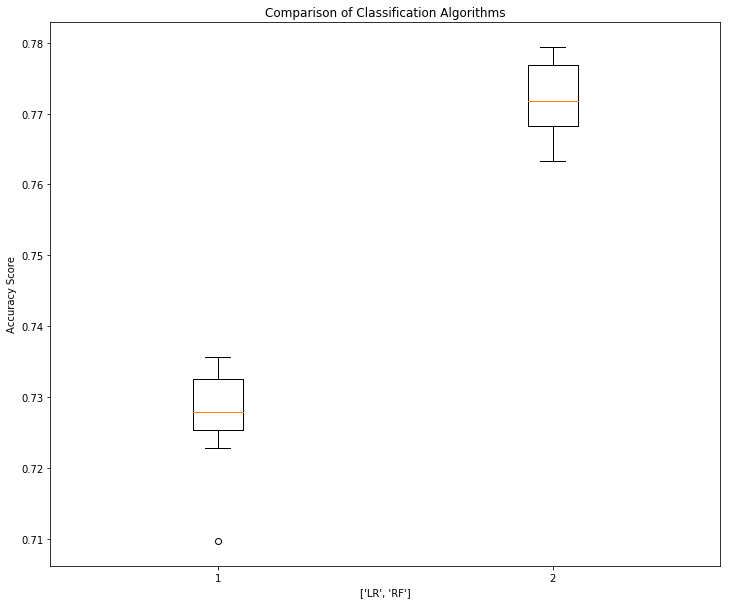

In [168]:

#Compare Algorithms

fig = plt.figure(figsize=(12,10))
plt.title('Comparison of Classification Algorithms')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy Score')
plt.boxplot(results)
#ax = fig.add_subplot(111)
plt.xlabel(names)
#ax.set_xticklabels(names)
plt.show()

In [237]:
bm = models[1][1]

In [238]:
bm.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [239]:
y_pred = bm.predict(X_test)

In [273]:
y_pred=clf.predict(X_test)

In [282]:
!catboost -v

/bin/sh: catboost: command not found


In [284]:
import catboost

AttributeError: type object '_catboost._FloatArrayWrapper' has no attribute '__reduce_cython__'

In [276]:
y_pred

array([ 0.47964843,  0.61985911,  0.65645296, ...,  0.65175665,
        0.65085438,  0.65070334])

In [274]:
accuracy_score(y_test, y_pred, normalize=True)

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [241]:
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.79      0.86      0.83     10719
functional needs repair       0.48      0.35      0.40      1425
         non functional       0.81      0.75      0.78      7458

            avg / total       0.78      0.78      0.78     19602



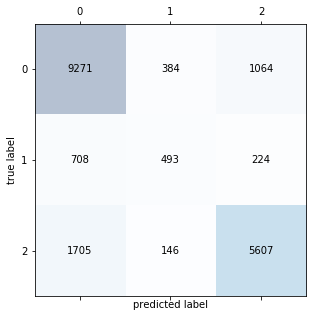

In [242]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig,ax = plt.subplots(figsize=(5,5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i,
               s=confmat[i,j],
               va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [243]:
# insted rf put best model
importances = bm.feature_importances_
std = np.std([tree.feature_importances_ for tree in bm.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
feature_names = np.array(list(X_train.columns.values))
feature_names

array(['public_meeting_False', 'public_meeting_True', 'permit_False',
       'permit_True', 'quantity_enough', 'quantity_insufficient',
       'quantity_other', 'quantity_seasonal',
       'waterpoint_type_communal standpipe',
       'waterpoint_type_communal standpipe multiple',
       'waterpoint_type_hand pump', 'waterpoint_type_improved spring',
       'waterpoint_type_other', 'quality_group_colored',
       'quality_group_fluoride', 'quality_group_good',
       'quality_group_milky', 'quality_group_other', 'quality_group_salty',
       'basin_internal', 'basin_lake nyasa', 'basin_lake rukwa',
       'basin_lake tanganyika', 'basin_lake victoria', 'basin_pangani',
       'basin_rufiji', 'basin_ruvuma / southern coast',
       'basin_wami / ruvu', 'source_dam', 'source_hand dtw', 'source_lake',
       'source_machine dbh', 'source_other', 'source_rainwater harvesting',
       'source_river', 'source_shallow well', 'source_spring',
       'scheme_management_company', 'scheme_manageme

In [ ]:
# one-hot-encod makes many sparsity columns, and models cound not take them into account
# from first article check TargetEncoder
# https://towardsdatascience.com/one-hot-encoding-multicollinearity-and-the-dummy-variable-trap-b5840be3c41a
# https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159
# for large number of cat_values try binarEncoding

In [ ]:
# from second how to make pipeline and use H2ORandomForest
# drop features which have importance less that 100th feature
# third post has Class Prediction Error (CPE) and link to post with NN
# concat train and test when we work with data, but in the end separeti them

In [107]:
lrc.fit(df_preproc_t, target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [108]:
ls

1.0-DP-beer_dataset.ipynb             SubmissionFormat.csv
1.1-DP_waterpomps.ipynb               beer_reviews.csv
1.3-DP_waterpomps_simplier.ipynb      prepeared_features.csv
1.4-DP_work_with_cats_features.ipynb  target.csv
2.0-DP_raw_data_visualization.ipynb   test.csv
2.1-DP_prepare_data.ipynb             train.csv


# make predictions

In [197]:
def prepare_numeric_features(df):
    df['missed_population'] = np.where(np.isnan(df['population']), 1, 0)
    df['population'].fillna(0, inplace = True)
    df['approximated_amount_tsh'] = np.where(np.isnan(df['amount_tsh']), 1, 0) 
    replacements = df.groupby('water_quality').amount_tsh.agg(pd.Series.mode).to_dict()
    replacements.pop('fluoride abandoned')
    df.loc[df['water_quality'] != 'soft', 'amount_tsh'] = \
        df.loc[df['water_quality'] != 'soft', 'amount_tsh'].fillna(replacements)
    df['amount_tsh'].fillna(0, inplace=True)
    df['wrong_gps_height'] = np.where(df['gps_height'] < 0, 1, 0) 
    df['gps_height'] = abs(df['gps_height'])
    return df


def prepare_categorical_features(df, categoricals):
    df[categoricals] = df[categoricals].astype('str')
    df[categoricals] = df[categoricals].applymap(lambda x: x.lower())
    nan_list = ['not known','unknown','none','-','##','not kno','unknown installer', '0', 'dwe']
    df = df.replace(nan_list, np.nan)

    # Any feature values with fewer than 50 rows would be turned into a 'other'
    for feature in df[categoricals]:
        # Determine which feature values to keep
        remove = df[feature].value_counts()[df[feature].value_counts() < 50].index.tolist()
        #print(remove)
        #to_keep = train[feature].value_counts()[train[feature].value_counts() > 50].index.tolist()

        # Turn those into NANs (using a copy, to prevent warnings)
        feature_copy = df[feature].copy()
        #feature_copy[~feature_copy.isin(to_keep)] = np.nan
        feature_copy[feature_copy.isin(remove)] = np.nan
        #print(feature_copy.isnull().sum())
        df[feature] = feature_copy
    # Fix all NANs
    df[categoricals] = df[categoricals].fillna('other') 
    df.management_group = df.management_group.apply(lambda x: 'other' if x != 'user-group' else x)
    unpayable_types = ['never pay', 'other']
    df.payment = df.payment.apply(lambda x: 0 if x in unpayable_types else 1)
    df.quantity.replace({'dry': 'other'}, inplace=True)
    df.waterpoint_type.replace({'cattle trough':'improved spring'}, inplace=True)
    df.drop(['region', 'district_code', 'extraction_type_group', 'extraction_type_class', 'management', 
             'management_group', 'payment_type', 'water_quality', 'quantity_group', 'source_class', 'source_type',
             'waterpoint_type_group'], 1, inplace=True)
    

    return df


def prepare_data_features(test_df, train_df):
    train_df_temp = train_df.copy()
    test_df[['date_recorded', 'construction_year']]= test_df[['date_recorded', 'construction_year']].apply((pd.to_datetime))
    train_df_temp['id'] = 0
    df = test_df.append(train_df_temp)
    df.construction_year.fillna(0, inplace=True)
    df.construction_year = df.construction_year.astype(int)
    df.construction_year = df.construction_year.replace(0, np.NaN)
    df['approximated_construction_year'] = df['construction_year'].apply(lambda x: 1 if np.isnan(x) else 0)
    replacements = df.groupby(['funder', 'installer'])['construction_year'].transform('mean').round(0)
    df['construction_year'] = df['construction_year'].fillna(replacements)

    replacements = df.groupby('installer')['construction_year'].transform('mean').round(0)
    df['construction_year'] = df['construction_year'].fillna(replacements)

    replacements = df.groupby('funder')['construction_year'].transform('mean').round(0)
    df['construction_year'] = df['construction_year'].fillna(replacements)

    df.construction_year.fillna(df.construction_year.mode()[0], inplace=True)

    return df[df.id != 0]

In [193]:
test_prep = prepare_numeric_features(test)

In [194]:
test_prep = prepare_categorical_features(test_prep, categoricals)

In [198]:
test_prep = prepare_data_features(test_prep, df)

In [ ]:
train_dum.columns

In [207]:
train_dum_t = pd.get_dummies(test_prep, dummy_na=False, prefix = categorial)
train_dum_t.shape

ValueError: Length of 'prefix' (12) did not match the length of the columns being encoded (32).

In [206]:
train_dum.shape

(59400, 4153)

In [200]:
test_prep.id

0        50785
1        51630
2        17168
3        45559
4        49871
5        52449
6        24806
7        28965
8        36301
9        54122
10         419
11       45750
12         653
13       14017
14       44607
15       40228
16       27714
17       28785
18       28330
19       18532
20       69961
21       55083
22        8691
23       30331
24       70970
25       61136
26       28799
27       46825
28       44718
29       37350
         ...  
14820    52228
14821    70038
14822    25901
14823    21131
14824    26580
14825    66059
14826    32944
14827    13686
14828     8471
14829    19620
14830    74162
14831    37994
14832    71151
14833    45017
14834    12592
14835    58693
14836    57539
14837    71252
14838     7869
14839    57316
14840    59757
14841    64579
14842    57731
14843    65541
14844    68174
14845    39307
14846    18990
14847    28749
14848    33492
14849    68707
Name: id, Length: 14850, dtype: int64

use get_dummies for test and train togather

In [201]:
pred = lrc.predict(test_prep)

ValueError: could not convert string to float: 'Kwa Mzee Chagala'

In [109]:
### or date recorder could be limitation of construction year
# Any feature values with fewer than 50 rows gets turned into a NAN, but this value better to test on cross-validation
# later
